Carga y preprocesamiento de imágenes --- 16:54 min
===

* Última modificación: Mayo 5, 2022 | [YouTube](https://youtu.be/GBLhxjzTTUs)

## Importación de librerías

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf

Descarga de archivos de ejemplo de TensorFlow
---

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(
    # -----------------------------------------------------------------------------------
    # Ubicacion donde seran guardados los archivos
    fname="flower_photos",
    # -----------------------------------------------------------------------------------
    # Direccion web de los archivos
    origin=dataset_url,
    # -----------------------------------------------------------------------------------
    # Extracción de archivos tar, zip, ...
    untar=True,
    # -----------------------------------------------------------------------------------
    # Directorio para almacenamiento de los datos
    cache_subdir="/tmp/",
)
data_dir

'/tmp/flower_photos'

In [3]:
import pathlib

#
# Crea un objeto para manipular los archivos
#
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/tmp/flower_photos')

Contenido de la carpeta de ejemplos
---

In [4]:
#
# Directorios
#
!ls -1 /tmp/flower_photos/

LICENSE.txt
daisy
dandelion
roses
sunflowers
tulips


In [5]:
#
# Cantidad de archivos
#
len(list(data_dir.glob("*/*.jpg")))

3670

Carga directa de los datos desde el directorio usando Keras
---

In [6]:
#
# Parámetros
#
params = {
    "directory": data_dir,
    "validation_split": 0.2,
    "seed": 12345,
    "image_size": (180, 180),
    "batch_size": 32,
}

train_params = {**params, **{"subset": "training"}}
val_params = {**params, **{"subset": "validation"}}

In [7]:
#
# Datos para entrenamiento
#
train_ds = tf.keras.utils.image_dataset_from_directory(**train_params)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
#
# Datos para validación
#
val_ds = tf.keras.utils.image_dataset_from_directory(**val_params)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
#
# Nombres de las clases
#
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Visualización de los datos
---

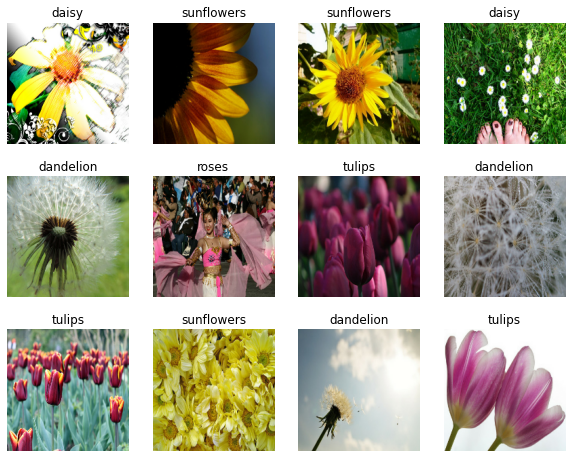

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Preprocesamiento de los datos
---

In [11]:
#
# Creación de una capa de re-escalado
#
rescaling_layer = tf.keras.layers.Rescaling(1.0 / 255)

#
# Aplica la función a cada imagen del dataset
#
rescaled_ds = train_ds.map(lambda x, y: (rescaling_layer(x), y))

#
# Se debe interar sobre cada batch
#
image_batch, labels_batch = next(iter(rescaled_ds))

Configuración del dataset para el desempeño
---

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

#
# cache: mantiene las images en memoria despues de la primera lectura
# prefetch: traslapa la lectura del bloque s+1 con el entrenamiento del bloque s.
# Ver: https://www.tensorflow.org/guide/data_performance#prefetching
#
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creación del modelo usando Sequential
---

In [13]:
num_classes = 5

model = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1.0 / 255),
        #
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        #
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        #
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),
        #
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(num_classes),
    ]
)

**Capa Conv2D**

![assets/Conv2D.png](assets/Conv2D.png)

**Capa MaxPooling2D**

![assets/MaxPooling2D.png](assets/MaxPooling2D.png)

Compilación y entrenamiento del modelo
---

In [14]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
)

Epoch 1/3
92/92 [==============================] - 38s 404ms/step - loss: 1.3439 - accuracy: 0.4097 - val_loss: 1.1973 - val_accuracy: 0.5054
Epoch 2/3
92/92 [==============================] - 35s 372ms/step - loss: 1.0475 - accuracy: 0.5804 - val_loss: 1.1008 - val_accuracy: 0.5477
Epoch 3/3
92/92 [==============================] - 35s 379ms/step - loss: 0.8896 - accuracy: 0.6529 - val_loss: 1.0235 - val_accuracy: 0.6104


**Nota.** El objetivo de esta lección es ejemplificar la carga de imágenes desde un directorio, por lo que no se analizará el modelo.